# Burocracy
1. checking GPU
2. install dependencies
3. import libraries

In [ ]:
##1. setting gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
## 2. installation
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
## 3. libraries

#standard python
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
#display plot in a notebook
%matplotlib inline
#plot style, just choises
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D #3D plot
from collections import defaultdict
from functools import partial

#graphic render of the environment
from IPython import display as ipythondisplay

# Setting up the environment

In [ ]:
env = gym.make('Blackjack-v1')
## useful if u want to look at the environment
#observation = env.reset()
#prev_screen = env.render(mode='rgb_array')
#plt.imshow(prev_screen)
#ipythondisplay.clear_output(wait=True)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


NOTE: usable ace means ace value is 1

# Policy function
take current state and check whether the score is greater than or equal to 20; if it is, we return 0, else we return 0. So, basically:

* **score >= 20** -----> stand, meaning u stop asking cards. **Return 0**
* **score < 20** -----> hit, meaning u ask cards. **Return 1**

In [ ]:
def sample_policy(observation):
  score, dealer_score, usable_ace = observation
  return 0 if score >= 20 else 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Generate an episode
Remember: in MC method the sample is the episode itself.

In [ ]:
## function generating an episode
def generate_episode(policy, env):
  states, actions, rewards = [], [], [] #each episode it's indipendent
  observation = env.reset() #initialize observation
  ## look at the initial environment
  #prev_screen = env.render(mode='rgb_array')
  #plt.imshow(prev_screen)
  #ipythondisplay.clear_output(wait=True)

  while True:
    states.append(observation)          #append observation to the states list
    action = sample_policy(observation) #action, 1 or 0, or stand or hit
    actions.append(action)              #saving the action
    observation, reward, done, info = env.step(action) # update things
    rewards.append(reward)
    #rendering the situation on screen
    #screen = env.render(mode='rgb_array')
    #plt.imshow(screen)
    #ipythondisplay.clear_output(wait=True)
    #ipythondisplay.display(plt.gcf())
    if done:
      break
  #ipythondisplay.clear_output(wait=True)
  return states, actions, rewards       #return the whole game parameters

# Actually play the game
First visit MC algorithm

In [ ]:
def first_visit_mc_prediction(policy, env, n_episodes):
  value_table = defaultdict(float)  #storing values of each state
  #state not yet visited: i think it's all 0, except for the state not yet visited, which have 1
  N = defaultdict(int)
  ## loop over the episodes, that means sampling things
  for _ in range(n_episodes):
    states, _, rewards = generate_episode(policy,env) #playing
    returns = 0 #initialize sum of rewards
    for t in range(len(states)-1,-1,-1):
      #calculate sum of rewards
      R = rewards[t]
      returns += R

      #checking first visit
      S = states[t]
      # if it's the first time we meet state S
      if S not in states[:t]:
        N[S] += 1
        value_table[S] += (returns-value_table[S])/N[S] #average of returns
  return value_table

# Look at the output

In [ ]:
 #cerchiamo di capire che diavolo fa
value = first_visit_mc_prediction(sample_policy,env,n_episodes = 100000)

# Useful plot to control the game

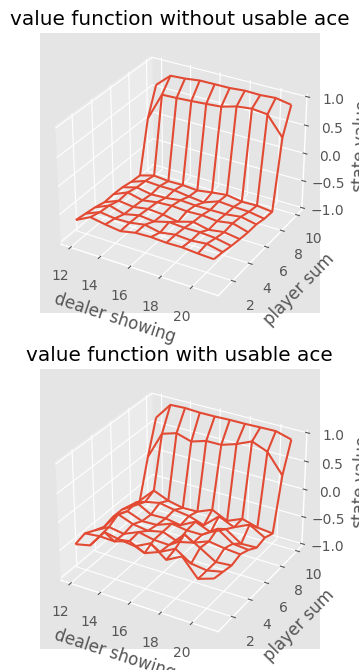

In [ ]:
#plot function
def plot_blackjack(V,ax1,ax2):
  player_sum = np.arange(12,21+1)
  dealer_show = np.arange(1,10+1)
  usable_ace = np.array([False, True])

  state_values = np.zeros((len(player_sum),len(dealer_show), len(usable_ace)))

  for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_show):
      for k, ace in enumerate(usable_ace):
        state_values[i,j,k] = V[player,dealer,ace]


  X, Y = np.meshgrid(player_sum, dealer_show)

  ax1.plot_wireframe(X,Y, state_values[:,:,0])
  ax2.plot_wireframe(X,Y, state_values[:,:,1])
  for ax in ax1,ax2:
    ax.set_zlim(-1,1)
    ax.set_ylabel('player sum')
    ax.set_xlabel('dealer showing')
    ax.set_zlabel('state-value')


#figurella
fig, axes = pyplot.subplots(nrows = 2, figsize = (5,8), \
                            subplot_kw = {'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])